# MSE403 Lab 7: Regularization
This lab is to perform feature selection and regularized regression on three ternary systems that make up ¾ of a Co-Zr-Cr-Ti quaternary metallic glass forming alloy. The goal is to generate predictions of the FWHM of this quaternary system using only the ternaries as training data.

#### Reference and Github copilot usage
The entire coding section of this lab report is written under the help of Github Copilot. The usage of large language model like ChatGPT will be marked.
A large section of code in this report is modified from MSE403 Practice 8. Any external reference will be marked.

## 1. Open the data, perform basic data preparation/cleaning
import the necessary packages, and read the data of each ternary system, concatenating them into a quaternary dataframe.

In [4]:
import scipy.io
import numpy.matlib as nm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import scipy

In [5]:
df_crtizr = pd.read_excel('Metallic Glass Data.xlsx', sheet_name='CrTiZr')   #read the data of each ternary system
df_crtizr = df_crtizr.dropna(axis=1)
df_crtizr['Co'] = 0   #For Co which does not exist in this ternary system, its composition would be set to 0

df_crcozr = pd.read_excel('Metallic Glass Data.xlsx', sheet_name='CrCoZr')
df_crcozr = df_crcozr.dropna(axis=1)
df_crcozr['Ti'] = 0

df_cotizr = pd.read_excel('Metallic Glass Data.xlsx', sheet_name='CoTiZr')
df_cotizr = df_cotizr.dropna(axis=1)
df_cotizr['Cr'] = 0

df_qua = pd.concat([df_crtizr, df_crcozr, df_cotizr], ignore_index=True)
df_qua = df_qua[['Cr', 'Co', 'Ti', 'Zr', 'MaxFWHM']]
#df_qua_nopoly = df_qua.copy()   #save the original dataframe for later use

In [6]:
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.composition import Miedema
from matminer.featurizers.composition import ElementProperty
from matminer.featurizers.composition import WenAlloys

Featurize the data

In [7]:

formula = 'Cr'+df_qua['Cr'].astype(str)+'Ti'+df_qua['Ti'].astype(str)+'Co'+df_qua['Co'].astype(str)+'Zr'+df_qua['Zr'].astype(str)
df_mat = pd.DataFrame({'Formula':formula, 'MaxFWHM':df_qua['MaxFWHM']})

#convert the formula from a string into chemical composition
df_mat = StrToComposition().featurize_dataframe(df_mat, "Formula")   #Featurization
df_mat = Miedema().featurize_dataframe(df_mat, col_id="composition")   #Featurization using Miedema featurizer

StrToComposition:   0%|          | 0/1323 [00:00<?, ?it/s]

Miedema:   0%|          | 0/1323 [00:00<?, ?it/s]

In [8]:
df_mat = WenAlloys().featurize_dataframe(df_mat, col_id="composition")   #Featurization using WenAlloys featurizer

WenAlloys:   0%|          | 0/1323 [00:00<?, ?it/s]

In [9]:
ep_feat = ElementProperty.from_preset(preset_name='magpie')

df_mat = ep_feat.featurize_dataframe(df_mat, col_id = 'composition')

ElementProperty:   0%|          | 0/1323 [00:00<?, ?it/s]

In [215]:
df_mat = df_mat.drop(['Weight Fraction','Atomic Fraction','composition','Formula'],axis=1,errors='ignore')
#add the Cr, Ti, Co, Zr composition to the dataframe
df_mat['Cr'] = df_qua['Cr']
df_mat['Ti'] = df_qua['Ti']
df_mat['Co'] = df_qua['Co']
df_mat['Zr'] = df_qua['Zr']
df_mat.to_csv('featruized.csv',index=False)

In [216]:
import lab7_function as mf

In [87]:
#import standard scaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

df_mat = pd.read_csv('featruized.csv')

mat_X = df_mat.drop(['MaxFWHM'], axis=1,errors='ignore')
to_drop = mf.drop_correlated_features(mat_X, 0.9)
#drop the correlated features
mat_X = mat_X.drop(to_drop, axis=1,errors='ignore')

mat_X_poly = mf.add_polynomical_features(mat_X,2)  #add 2 degree polynomial features

mat_y = df_mat['MaxFWHM']

#Standardize the data
sc = StandardScaler()
sc.fit(mat_X)
mat_X_std = sc.transform(mat_X)

sc_poly = StandardScaler()
sc_poly.fit(mat_X_poly)
mat_X_poly_std = sc_poly.transform(mat_X_poly)





C:\Users\28452\AppData\Local\Temp\ipykernel_51212\4136208615.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


## 2. Demonstrate your ability to use LASSO to perform feature selection.

The Hyperparameter tuning functions are borrowed from:
https://towardsdatascience.com/hyperparameter-tuning-in-lasso-and-ridge-regressions-70a4b158ae6d

C:\Users\28452\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.015e+00, tolerance: 2.039e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\28452\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.972e+00, tolerance: 2.090e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\28452\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.667e+00, toleranc

The best validation score is 0.8138543523020303 at alpha = 2.5595479226995334e-06


C:\Users\28452\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.015e+00, tolerance: 2.039e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\28452\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.972e+00, tolerance: 2.090e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\28452\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.667e+00, toleranc

Text(0.5, 1.0, 'Lasso MSE vs Regularization Parameter')

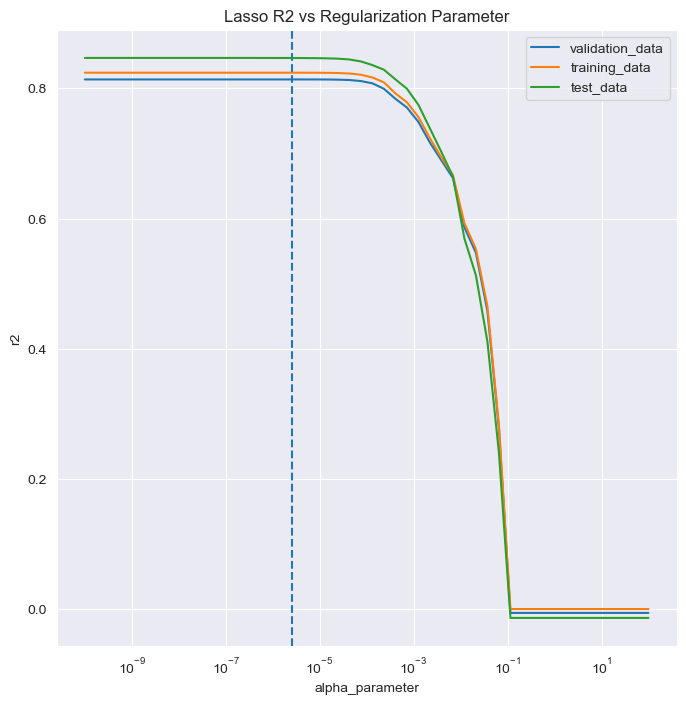

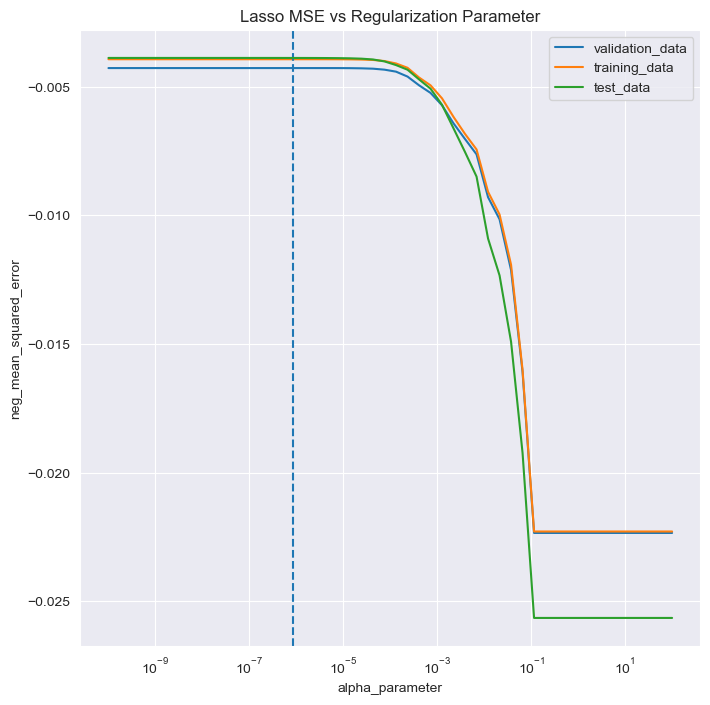

In [144]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import get_scorer
import seaborn as sns
from sklearn.linear_model import Lasso



cv = KFold(n_splits=5, shuffle=True, random_state=0)  #define cross validation method
lasso_alphas = np.logspace(-10, 2, 50)   #define the range of alpha
X_mat_train_std , X_mat_test_std, y_mat_train, y_mat_test = train_test_split(mat_X_poly_std, mat_y, test_size=200, random_state=0)   #Perform Train-Test split

lasso_chosen_alpha, lasso_max_validation_score, lasso_test_score = mf.regmodel_param_test(
    lasso_alphas, X_mat_train_std, y_mat_train, cv, scoring = 'r2',
    model_name = 'LASSO', X_test = X_mat_test_std, y_test = y_mat_test,
    draw_plot = True, filename = 'lasso')
#The function would create a plot of R2 vs alpha and return the best alpha and the corresponding R2 score

plt.xscale('log')
plt.title('Lasso R2 vs Regularization Parameter')

print('The best validation score is '+ str(lasso_max_validation_score) + ' at alpha = ' + str(lasso_chosen_alpha))

#-----------------------------------------------MSE plot
mf.regmodel_param_test(
    lasso_alphas, X_mat_train_std, y_mat_train, cv, scoring = 'neg_mean_squared_error',
    model_name = 'LASSO', X_test = X_mat_test_std, y_test = y_mat_test,
    draw_plot = True, filename = 'lasso_mse')
#The function would create a plot of MSE vs alpha and return the best alpha and the corresponding MSE score

plt.xscale('log')
plt.title('Lasso MSE vs Regularization Parameter')

As shown in the plot, the best alpha is selected based on the best validation score.

Create a plot showing the coefficients descend in magnitude as the regularization parameter increases. Also another plot is shown with the informative features (feature names are shown in the plot) selected by Lasso.

C:\Users\28452\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12786811807904996, tolerance: 0.033630307276844844
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\28452\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0438200742773347, tolerance: 0.033630307276844844
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\28452\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6519699227245042, tolerance: 0.033630307276844844
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\28452\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desce

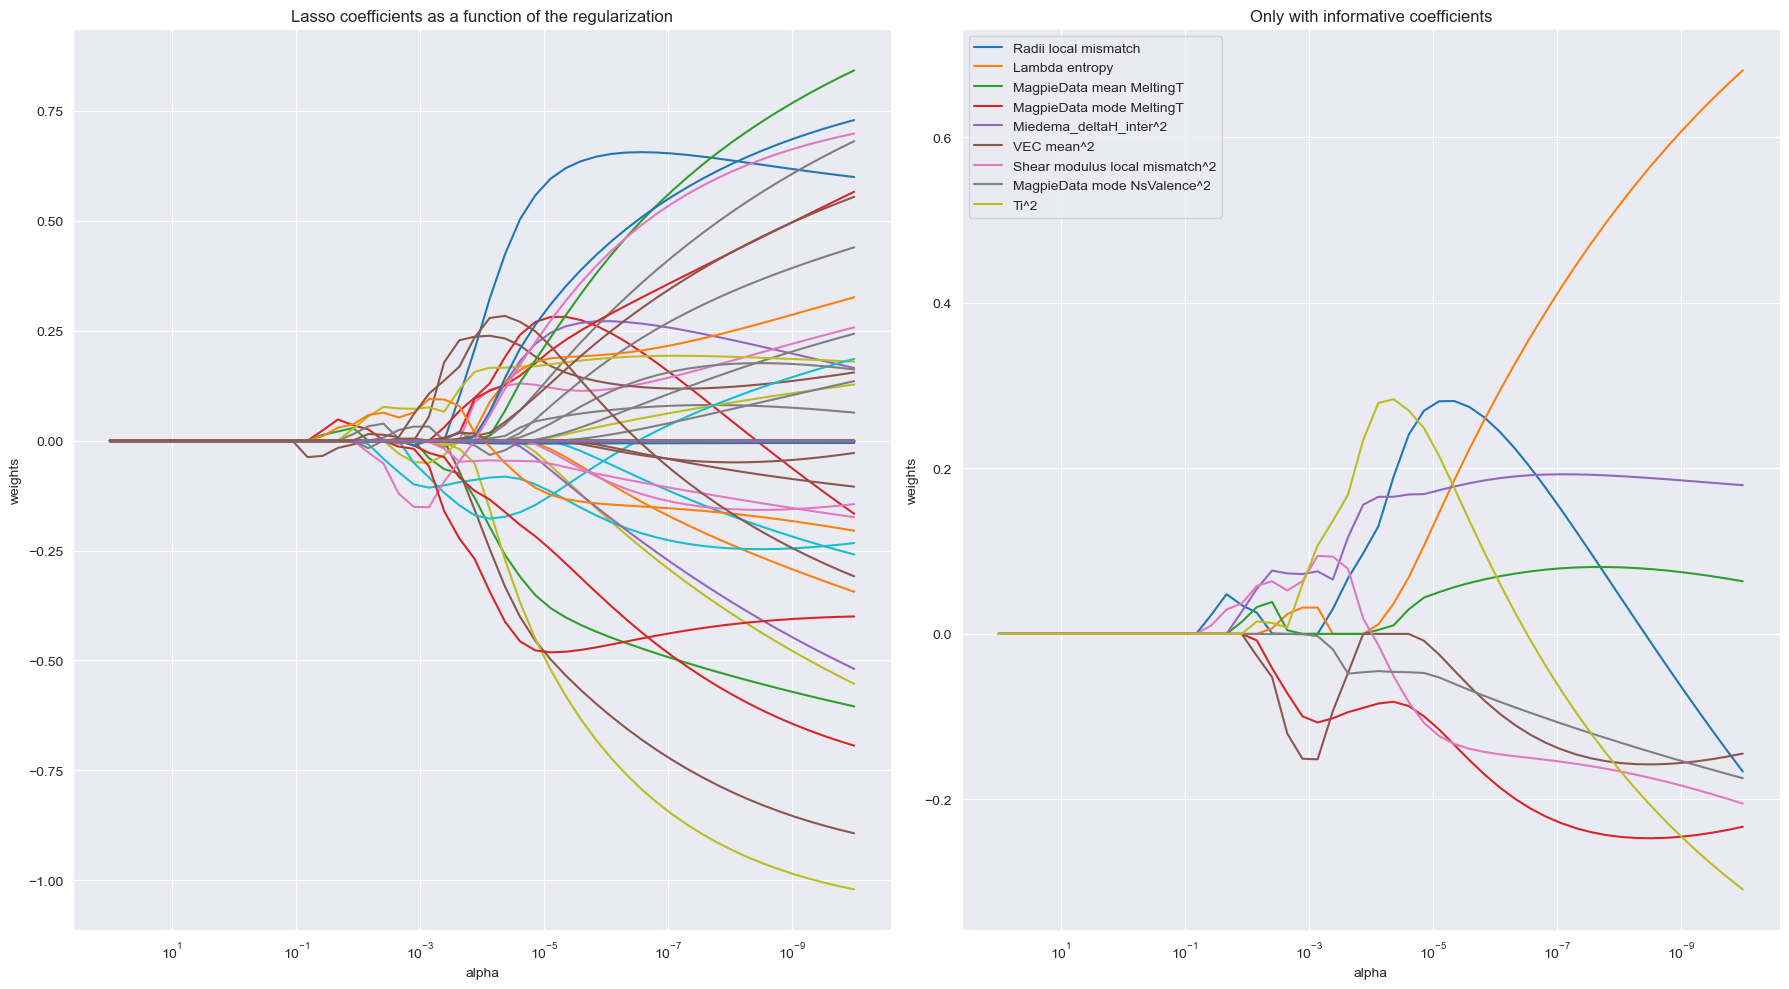

In [146]:
from sklearn.linear_model import lasso_path

n_alphas = 50
alphas = np.logspace(-10, 2, n_alphas)
#get the index for aplha equal to lasso_chosen_alpha
lasso_chosen_alpha_index = np.where(alphas==lasso_chosen_alpha)[0][0]

alphas_lasso, coefs_lasso, _ = lasso_path(mat_X_poly_std, mat_y, alphas=alphas)
#creat a plot of the coefficients
plt.figure(figsize=(18, 10))
#coefs_lasso = coefs_lasso[coef!=0]
#only keep the coefficients that are not 0
plt.subplot(1, 2, 1)
plt.plot(alphas_lasso, coefs_lasso.T)
ax = plt.gca()
ax.set_xscale("log")
ax.invert_xaxis()
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')

chosen_alpha_coef = coefs_lasso[:,lasso_chosen_alpha_index]

plt.subplot(1, 2, 2)
plt.plot(alphas_lasso, coefs_lasso[chosen_alpha_coef!=0].T, label = mat_X_poly.columns[chosen_alpha_coef!=0])
ax = plt.gca()
ax.set_xscale("log")
ax.invert_xaxis()
plt.xlabel('alpha')
plt.ylabel('weights')
plt.legend()
plt.title('Only with informative coefficients')
#tight layout
plt.tight_layout()

At the best alpha selected, use Lasso to drop all the coefficients that are 0.

In [218]:
mat_X_poly_reg = mat_X_poly.loc[:,mat_X_poly.columns[chosen_alpha_coef!=0]]

## 3. Fit Ridge Regression to your data and remaining features

In [159]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV

sc = StandardScaler()  #standardize the data
mat_X_poly_reg_std = sc.fit_transform(mat_X_poly_reg)

RRCV = RidgeCV(alphas=[1e-6,1e-5,1e-4, 1e-3, 1e-2, 1e-1, 1], cv = 5).fit(mat_X_poly_reg_std, mat_y)
print(RRCV.alpha_)
print(RRCV.coef_)
#The ridge cv is just for preliminary test, the alpha parameter is tuned later


1e-06
[-0.10680188  0.09425258 -0.05377197 -0.1162335   0.11569533 -0.25088361
  0.08381095 -0.0603787   0.01325795]


Tune the alpha hyperparameter using the function defined above.

The best validation score is 0.7645356012142501 at alpha = 0.06551285568595495


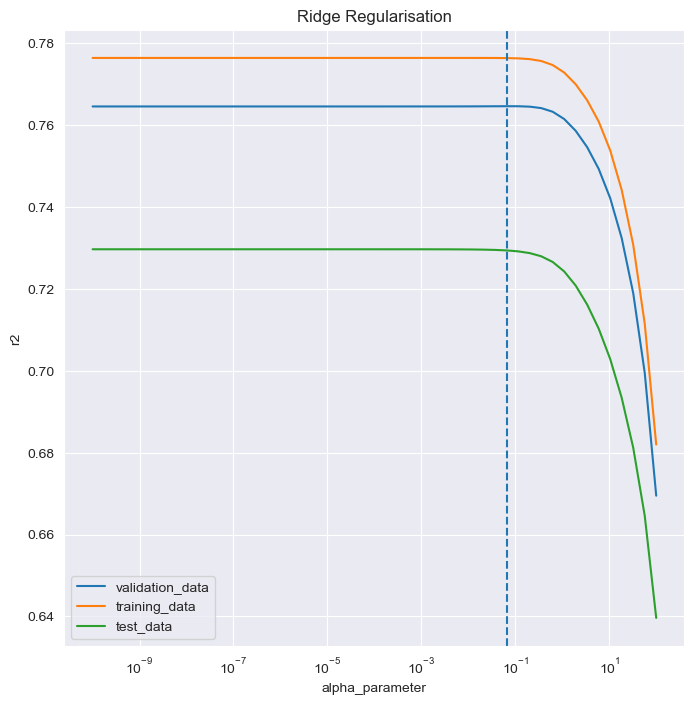

In [161]:
ridge_alphas = np.logspace(-10, 2, n_alphas)  #define the range of alpha
X_mat_train_std , X_mat_test_std, y_mat_train, y_mat_test = train_test_split(mat_X_poly_reg_std, mat_y, test_size=1000, random_state=0)   #Perform Train-Test split

ridge_chosen_alpha, ridge_max_validation_score, ridge_test_score = mf.regmodel_param_test(
    ridge_alphas, X_mat_train_std, y_mat_train, cv, scoring = 'r2',
    model_name = 'Ridge', X_test = X_mat_test_std, y_test = y_mat_test,
    draw_plot = True, filename = 'ridge')
#The function would create a plot of R2 vs alpha and return the best alpha and the corresponding R2 score

plt.xscale('log')

print('The best validation score is '+ str(ridge_max_validation_score) + ' at alpha = ' + str(ridge_chosen_alpha))
#the validation score at teh best alpha


Create a plot showing the coefficients descend in magnitude as the Ridge alpha parameter increases.

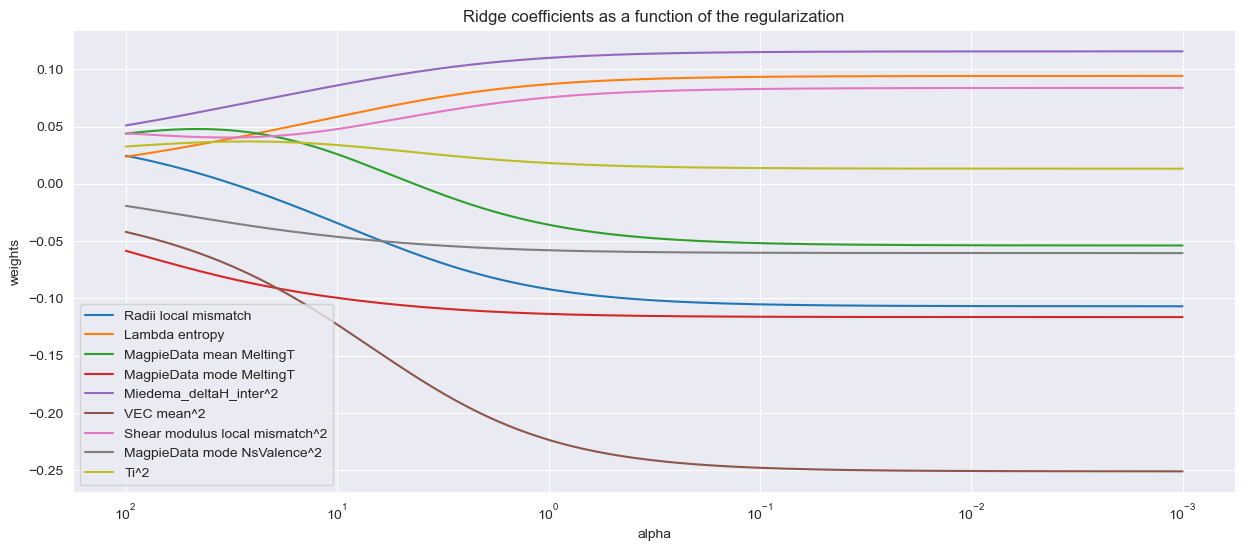

In [167]:
n_alphas = 200
#generate numpy array of alphas without logspace

alphas = np.logspace(-3, 2, n_alphas)

coefs = []
for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=True)
    ridge.fit(mat_X_poly_reg_std, mat_y)
    coefs.append(ridge.coef_.ravel())

# Display results
plt.figure(figsize=(15, 6))
ax = plt.gca()
ax.plot(alphas, coefs, label = mat_X_poly_reg.columns)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")
plt.legend()
plt.show()

Text(0.5, 1.0, 'Train Error (Ridge)')

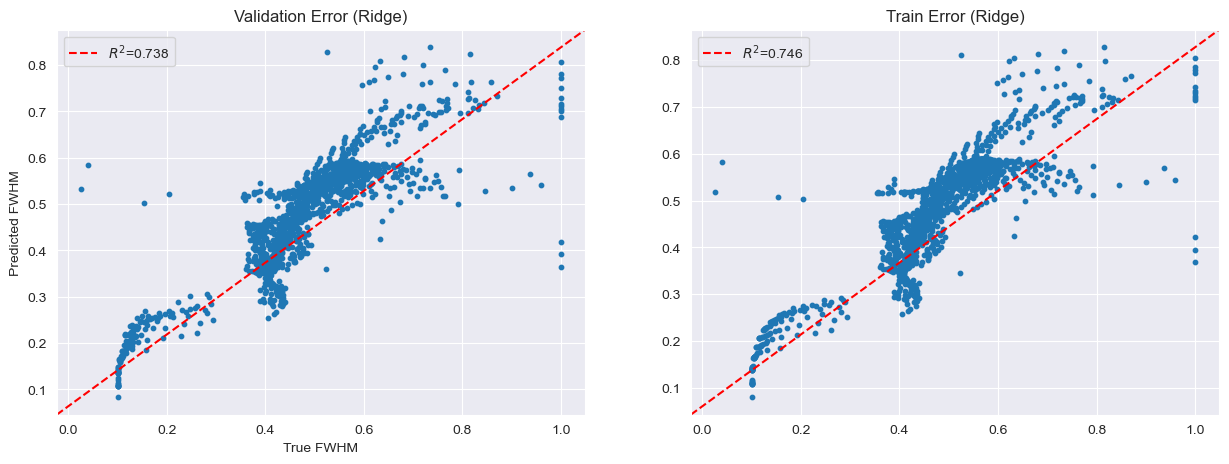

In [168]:
ridge = Ridge(alpha=ridge_chosen_alpha, fit_intercept=True)

random_list = mf.random_cv(mat_X_poly_reg, mat_y, n_split=5)   #Perform random cv

mat_y_pred = np.zeros(mat_y.shape)
for i, group in enumerate(random_list):   #Random CV with Ridge
    train_index, test_index, X_train, X_test, y_train, y_test = group
    ridge.fit(X_train,y_train)
    y_test_pred = ridge.predict(X_test)
    mat_y_pred[test_index] = y_test_pred

#---------------------Validation Error---------------------
plt.figure(figsize=(15,5))   #Make parity plot
plt.subplot(1,2,1)
plt.scatter(mat_y, mat_y_pred,s=10)
#get the r2 score
r2_score(mat_y, mat_y_pred)
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls='--', c='r', label='$R^{2}$='+ str(round(r2_score(mat_y, mat_y_pred),3)))
plt.legend()
plt.xlabel('True FWHM')
plt.ylabel('Predicted FWHM')
plt.title('Validation Error (Ridge)')

#---------------------Train Error---------------------

ridge.fit(mat_X_poly_reg_std, mat_y)
mat_y_pred = ridge.predict(mat_X_poly_reg_std)
plt.subplot(1,2,2)
plt.scatter(mat_y, mat_y_pred,s=10)
#get the r2 score
r2_score(mat_y, mat_y_pred)
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls='--', c='r', label='$R^{2}$='+ str(round(r2_score(mat_y, mat_y_pred),3)))
plt.legend()
plt.xlabel('True FWHM')
plt.ylabel('Predicted FWHM')
plt.title('Train Error (Ridge)')



## 4. Predict the FWHM for the entire Co-Zr-Cr-Ti quaternary phase diagram (use 5 at.% increments)

Create the quaternary dataset

In [214]:
dict_entire_qua = {'Cr':[], 'Ti':[], 'Co':[], 'Zr':[]}  #copilot

for cr in np.arange(0,1.05,0.05):   #Creat the quaternary composition dataframe with 5 at.% increments
    for ti in np.arange(0,1.05,0.05):
        for co in np.arange(0,1.05,0.05):
            for zr in np.arange(0,1.05,0.05):
                if cr+ti+co+zr == 1.0:
                    dict_entire_qua['Cr'].append(round(cr,3))
                    dict_entire_qua['Ti'].append(round(ti,3))
                    dict_entire_qua['Co'].append(round(co,3))
                    dict_entire_qua['Zr'].append(round(zr,3))

df_entire_qua = pd.DataFrame(dict_entire_qua)

df_entire_qua

,Cr,Ti,Co,Zr
0,0.00,0.00,0.00,1.00
1,0.00,0.00,0.05,0.95
2,0.00,0.00,0.10,0.90
3,0.00,0.00,0.15,0.85
4,0.00,0.00,0.20,0.80
...,...,...,...,...
1579,0.90,0.10,0.00,0.00
1580,0.95,0.00,0.00,0.05
1581,0.95,0.00,0.05,0.00
1582,0.95,0.05,0.00,0.00


Featurization using the same featurizer

In [69]:
formula = 'Cr'+df_entire_qua['Cr'].astype(str)+'Ti'+df_entire_qua['Ti'].astype(str)+'Co'+df_entire_qua['Co'].astype(str)+'Zr'+df_entire_qua['Zr'].astype(str)
df_entire_mat = pd.DataFrame({'Formula':formula})

#convert the formula from a string into chemical composition
df_entire_mat = StrToComposition().featurize_dataframe(df_entire_mat, "Formula")
df_entire_mat = Miedema().featurize_dataframe(df_entire_mat, col_id="composition")
df_entire_mat = WenAlloys().featurize_dataframe(df_entire_mat, col_id="composition")

StrToComposition:   0%|          | 0/1584 [00:00<?, ?it/s]

Miedema:   0%|          | 0/1584 [00:00<?, ?it/s]

WenAlloys:   0%|          | 0/1584 [00:00<?, ?it/s]

In [70]:
ep_feat = ElementProperty.from_preset(preset_name='magpie')

df_entire_mat = ep_feat.featurize_dataframe(df_entire_mat, col_id = 'composition')

ElementProperty:   0%|          | 0/1584 [00:00<?, ?it/s]

In [71]:
df_entire_mat = df_entire_mat.drop(['Weight Fraction','Atomic Fraction','composition','Formula'],axis=1,errors='ignore')
#add composition data
df_entire_mat = df_entire_mat.drop(['Cr','Ti','Co','Zr'],axis=1,errors='ignore')

df_entire_mat_comp = pd.concat([df_entire_qua,df_entire_mat],axis=1)
df_entire_mat_comp.to_csv('Matminer_Quaternary.csv',index=False)

The same data preprocessing as the previous ternary dataset

In [192]:
entire_X = pd.read_csv('Matminer_Quaternary.csv')

entire_Yang_delta = entire_X['Yang delta']
entire_Yang_omega = entire_X['Yang omega']

entire_X = entire_X.drop(to_drop,axis=1,errors='ignore')
entire_X_poly = mf.add_polynomical_features(entire_X, degree=2)

In [193]:
entire_X_poly_reg = entire_X_poly[mat_X_poly_reg.columns]   #Use the same features

sc = StandardScaler()   #Standardize the data
entire_X_poly_reg_std = sc.fit_transform(entire_X_poly_reg)

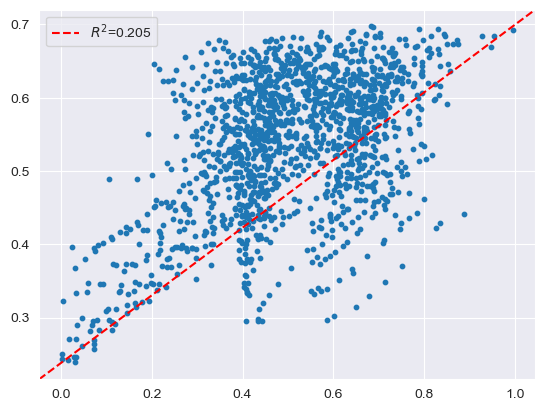

In [194]:
ridge = Ridge(alpha=ridge_chosen_alpha, fit_intercept=True)
ridge.fit(mat_X_poly_reg_std, mat_y)
entire_y_pred = ridge.predict(entire_X_poly_reg_std)   #Use previous model to predict the quaternary dataset

lab5_mat_y_pred = np.load('mat_Y_pred.npy')   #Read the prediction data from lab 5

index = np.where((lab5_mat_y_pred<0) | (lab5_mat_y_pred>1))
index1 = np.where((entire_y_pred<0) | (entire_y_pred>1))
index2 = np.concatenate((index,index1),axis=1)   #Drop the outliers that is beyond the FWHM range of 0-1

lab5_mat_y_pred_del = np.delete(lab5_mat_y_pred, index2)
entire_y_pred_del = np.delete(entire_y_pred, index2)   #Drop outliers

#Create the parity plot
plt.scatter(entire_y_pred_del, lab5_mat_y_pred_del,s=10)

r2_score(entire_y_pred_del, lab5_mat_y_pred_del)
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls='--', c='r', label='$R^{2}$='+ str(round(r2_score(entire_y_pred_del, lab5_mat_y_pred_del),3)))
plt.legend()
plt.title('Comparing the predictions in Lab 5 and Lab 7')
plt.xlabel('Lab 7')
plt.ylabel('Lab 5')

Plot the result on Young's Plot and shows the predicted metallic glass

(0.0, 8.0)

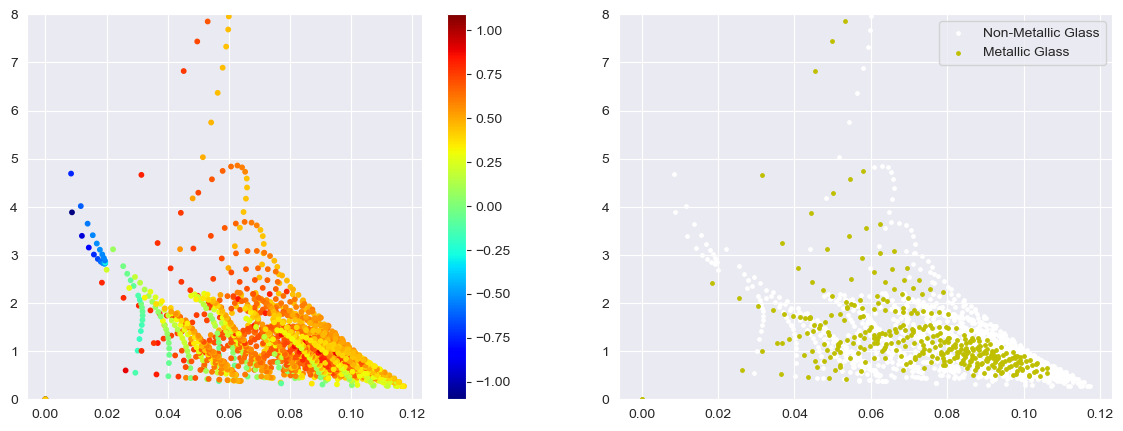

In [210]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.scatter(entire_Yang_delta, entire_Yang_omega,c=entire_y_pred,s=10,cmap='jet')   #Yang's plot
#change the color of the plot

plt.ylim(0,8)
plt.colorbar()

plt.subplot(1,2,2)   #shows the predicted metallic glass
plt.scatter(entire_Yang_delta[entire_y_pred<=0.65], entire_Yang_omega[entire_y_pred<=0.65],c='white',s=6,label = 'Non-Metallic Glass')
plt.scatter(entire_Yang_delta[entire_y_pred>0.65], entire_Yang_omega[entire_y_pred>0.65],c='y',s=6,label = 'Metallic Glass')
plt.legend()
plt.ylim(0,8)

The metallic glass threshold is set to be 0.65 since that aligns with the traing data and the classification models in the last lab.

## Summary
- In this lab, we used the broader side of MatMiner and Magpie to generate 100+ features for the ternary dataset, and utilized regularization techniques like Lasso to select the most informative features to avoid overfitting.
- The Lasso Hyperparameter is carefully tuned by maximizing the validation score of the model in random cross validation.
- After the Lasso feature selection, only 9 most important features are left from the 100+ feature set, and all other features'coefficients are dropped to zero during the regularization process.
- Ridge regression is used on the remaining feature set to further reduce the multicollinearity and improve the model performance.
- The alpha hyperparameter of the Ridge regression is also tuned by maximizing the validation score of the model in random cross validation.
- Finally, the model is fitted on the entire ternary dataset and predicted the metallic glass forming ability of the quaternary dataset.
